# Data Wrangling Project Check-In
## Connor Ellis
### April 24th 2025

#### Data Processing

In [3]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [4]:
#load datasets
project_df = pd.read_csv('cellis3_project_data.csv', parse_dates = ['Date'])
project_df.set_index('Date',inplace = True)
project_df.drop(columns = ['Unnamed: 0','country_region_code','country_region'], inplace=True)
project_df

,New_Cases,New_Deaths,Value,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
Date,,,,,,,,,
2020-02-17,0,0,NaN,6.0,0.0,28.0,-9.0,-24.0,5.0
2020-02-18,0,0,3370.29,0.0,-1.0,6.0,1.0,0.0,1.0
2020-02-19,0,0,3386.15,2.0,0.0,8.0,1.0,1.0,0.0
2020-02-20,0,0,3373.23,1.0,0.0,4.0,0.0,0.0,1.0
2020-02-21,20,0,3337.75,2.0,-2.0,4.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2024-04-08,2331,28,5202.39,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-09,2361,38,5209.91,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-10,2555,30,5160.64,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Forward fill S&P 500 values
project_df['Value'] = project_df['Value'].ffill()
#for mobility metrics, fill missing with rolling mean (7-day window)
mobility_cols = [
    'retail_and_recreation_percent_change_from_baseline',
    'grocery_and_pharmacy_percent_change_from_baseline',
    'parks_percent_change_from_baseline',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline'
]
for col in mobility_cols:
    project_df[col] = project_df[col].fillna(project_df[col].rolling(7,min_periods = 1).mean())

#create derived variables
#s&p daily returns
project_df['SP500_Daily_Return'] = project_df['Value'].pct_change()

#covid rolling averages from previous day
project_df['New_Cases_7d_avg'] = project_df['New_Cases'].rolling(7).mean()
project_df['New_Cases_12d_avg'] = project_df['New_Cases'].rolling(7).mean()
for col in mobility_cols:
    project_df[f'{col}_change'] = project_df[col].pct_change()

#create lagged variables
lags = [1,3,5,7] #days to lag
for lag in lags:
    #lag covid metrics
    project_df[f'New_Cases_lag_{lag}'] = project_df['New_Cases'].shift(lag)
    project_df[f'New_Deaths_lag_{lag}'] = project_df['New_Deaths'].shift(lag)

    #lag mobility metrics
    for col in mobility_cols:
        project_df[f'{col}_lag{lag}'] = project_df[col].shift(lag)
#trading days vs. all days
project_df['is_trading_day'] = project_df['Value'].notna()

#split data set into all days and trading days only
all_days = project_df.copy()
trading_days = project_df[project_df['is_trading_day']].copy()

#weekly aggregations
weekly = project_df.resample('W-FRI').agg({
    'New_Cases':'sum',
    'New_Deaths':'sum',
    'Value':'last', #SP closing on friday
    'retail_and_recreation_percent_change_from_baseline':'mean',
    'grocery_and_pharmacy_percent_change_from_baseline' : 'mean',
    'workplaces_percent_change_from_baseline':'mean',
    'residential_percent_change_from_baseline':'mean'
    })
#save processed data
all_days.to_csv('processed_all_days.csv')
trading_days.to_csv('processed_trading_days.csv')
weekly.to_csv('processed_weekly.csv')
project_df

,New_Cases,New_Deaths,Value,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,SP500_Daily_Return,...,residential_percent_change_from_baseline_lag5,New_Cases_lag_7,New_Deaths_lag_7,retail_and_recreation_percent_change_from_baseline_lag7,grocery_and_pharmacy_percent_change_from_baseline_lag7,parks_percent_change_from_baseline_lag7,transit_stations_percent_change_from_baseline_lag7,workplaces_percent_change_from_baseline_lag7,residential_percent_change_from_baseline_lag7,is_trading_day
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-17,0,0,NaN,6.0,0.0,28.0,-9.0,-24.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2020-02-18,0,0,3370.29,0.0,-1.0,6.0,1.0,0.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2020-02-19,0,0,3386.15,2.0,0.0,8.0,1.0,1.0,0.0,0.004706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2020-02-20,0,0,3373.23,1.0,0.0,4.0,0.0,0.0,1.0,-0.003816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2020-02-21,20,0,3337.75,2.0,-2.0,4.0,1.0,0.0,0.0,-0.010518,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-08,2331,28,5202.39,NaN,NaN,NaN,NaN,NaN,NaN,-0.000375,...,NaN,4511.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-04-09,2361,38,5209.91,NaN,NaN,NaN,NaN,NaN,NaN,0.001445,...,NaN,4396.0,42.0,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-04-10,2555,30,5160.64,NaN,NaN,NaN,NaN,NaN,NaN,-0.009457,...,NaN,3449.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,True


#### Bivariate

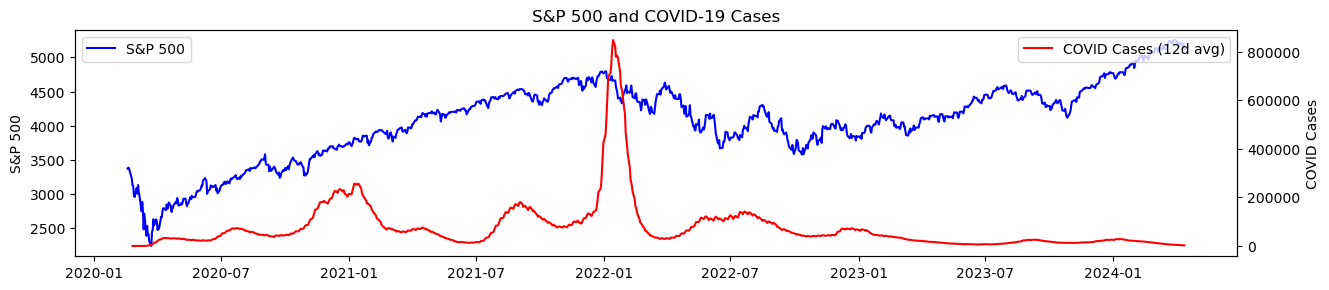

In [7]:
#initial visualization
#plot 1 sp 500 ad covid cases 7d and 12d avg
plt.figure(figsize = (15,10))
plt.subplot(3,1,1)
plt.plot(project_df.index, project_df['Value'], 'b-', label = 'S&P 500')
plt.ylabel('S&P 500')
plt.legend(loc = 'upper left')
ax2 = plt.gca().twinx()
ax2.plot(project_df.index, project_df['New_Cases_12d_avg'], 'r-', label = 'COVID Cases (12d avg)')
ax2.set_ylabel('COVID Cases')
plt.title('S&P 500 and COVID-19 Cases')
plt.legend(loc = 'upper right')

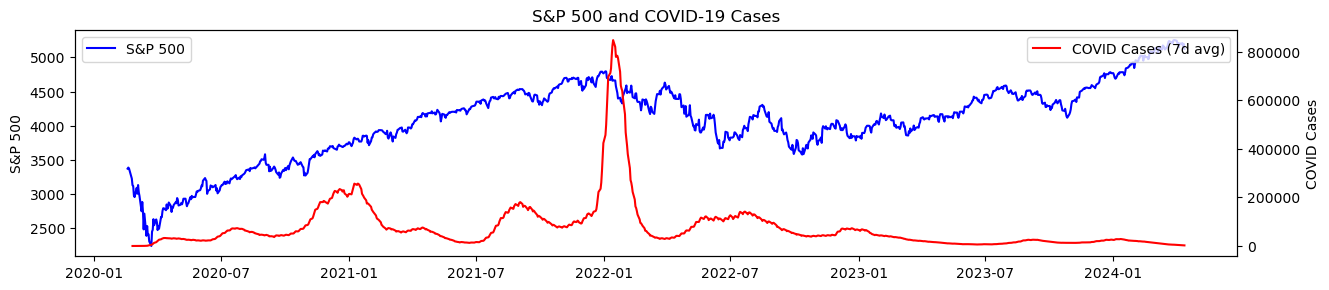

In [8]:
plt.figure(figsize = (15,10))
plt.subplot(3,1,1)
plt.plot(project_df.index, project_df['Value'], 'b-', label = 'S&P 500')
plt.ylabel('S&P 500')
plt.legend(loc = 'upper left')
ax2 = plt.gca().twinx()
ax2.plot(project_df.index, project_df['New_Cases_7d_avg'], 'r-', label = 'COVID Cases (7d avg)')
ax2.set_ylabel('COVID Cases')
plt.title('S&P 500 and COVID-19 Cases')
plt.legend(loc = 'upper right')

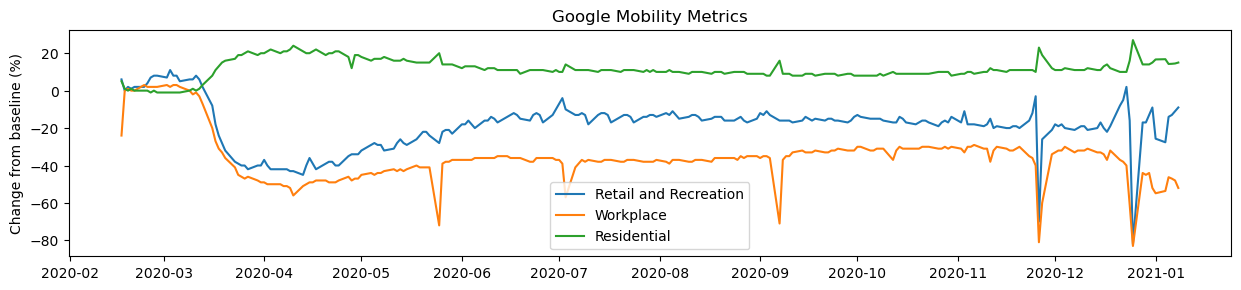

In [9]:
#plot2 mobility metrics
plt.figure(figsize = (15,10))
plt.subplot(3,1,2)
plt.plot(project_df.index, project_df['retail_and_recreation_percent_change_from_baseline'], label = 'Retail and Recreation')
plt.plot(project_df.index, project_df['workplaces_percent_change_from_baseline'], label = 'Workplace')
plt.plot(project_df.index,project_df['residential_percent_change_from_baseline'],label = 'Residential')
plt.ylabel('Change from baseline (%)')
plt.title('Google Mobility Metrics')
plt.legend()

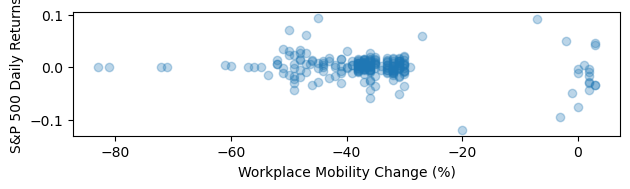

In [10]:
#plot 3: s&p 500 returns vs mobility
plt.subplot(3,1,3)
plt.scatter(
    project_df['workplaces_percent_change_from_baseline'],
    project_df['SP500_Daily_Return'],
    alpha = .3
)
plt.xlabel('Workplace Mobility Change (%)')
plt.ylabel('S&P 500 Daily Returns')
plt.tight_layout()
plt.show()

In [11]:
trading_days

,New_Cases,New_Deaths,Value,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,SP500_Daily_Return,...,residential_percent_change_from_baseline_lag5,New_Cases_lag_7,New_Deaths_lag_7,retail_and_recreation_percent_change_from_baseline_lag7,grocery_and_pharmacy_percent_change_from_baseline_lag7,parks_percent_change_from_baseline_lag7,transit_stations_percent_change_from_baseline_lag7,workplaces_percent_change_from_baseline_lag7,residential_percent_change_from_baseline_lag7,is_trading_day
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-18,0,0,3370.29,0.0,-1.0,6.0,1.0,0.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2020-02-19,0,0,3386.15,2.0,0.0,8.0,1.0,1.0,0.0,0.004706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2020-02-20,0,0,3373.23,1.0,0.0,4.0,0.0,0.0,1.0,-0.003816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2020-02-21,20,0,3337.75,2.0,-2.0,4.0,1.0,0.0,0.0,-0.010518,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2020-02-24,18,0,3225.89,2.0,1.0,9.0,1.0,3.0,0.0,-0.033514,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-08,2331,28,5202.39,NaN,NaN,NaN,NaN,NaN,NaN,-0.000375,...,NaN,4511.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-04-09,2361,38,5209.91,NaN,NaN,NaN,NaN,NaN,NaN,0.001445,...,NaN,4396.0,42.0,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-04-10,2555,30,5160.64,NaN,NaN,NaN,NaN,NaN,NaN,-0.009457,...,NaN,3449.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,True


Text(0.5, 1.0, 'Correlation Matrix')

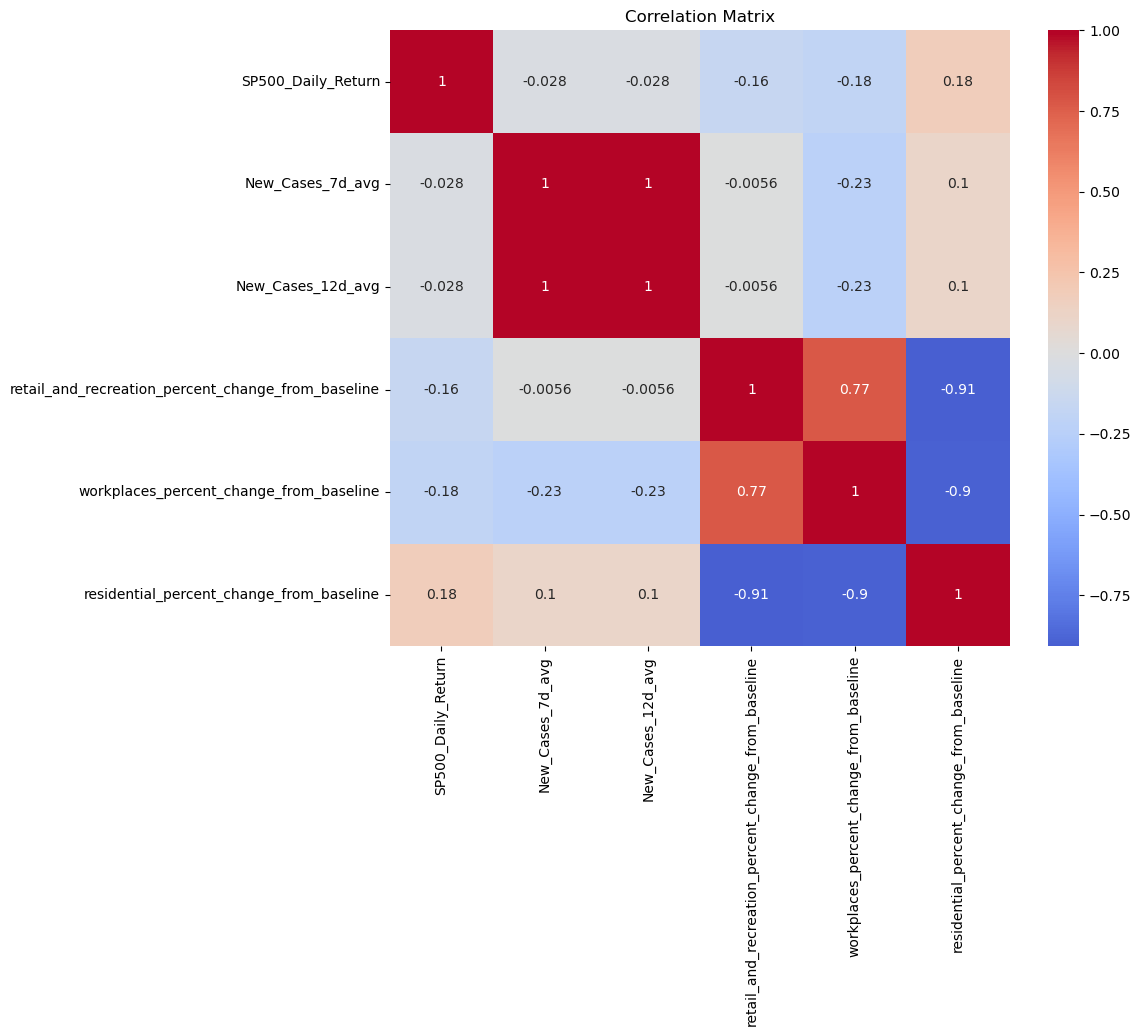

In [12]:
#correlation analysist

corr_cols = [
    'SP500_Daily_Return',
    'New_Cases_7d_avg',
    'New_Cases_12d_avg',
    'retail_and_recreation_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline'
]
corr_matrix = trading_days[corr_cols].corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', center = 0)
plt.title('Correlation Matrix')

#### EDA and Univariate

Text(0, 0.5, 'Frequency')

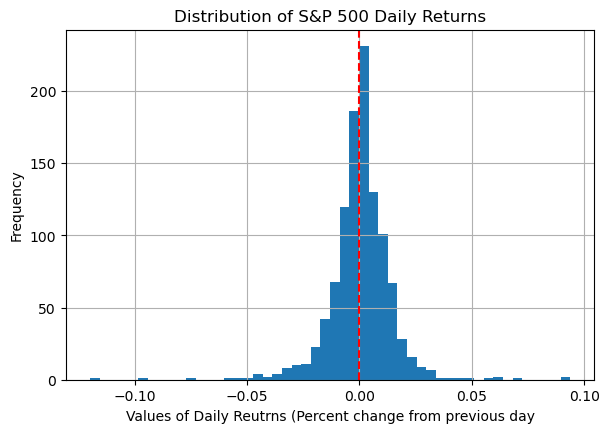

In [14]:
#univariate analysis of key variables
plt.figure(figsize = (15,10))

#distribution of SP500 daily returns
plt.subplot(2,2,1)
trading_days['SP500_Daily_Return'].hist(bins = 50)
plt.title('Distribution of S&P 500 Daily Returns')
plt.axvline(0, color = 'red', linestyle = '--')
plt.xlabel('Values of Daily Reutrns (Percent change from previous day')
plt.ylabel('Frequency')

Text(0, 0.5, 'count of days with that number of cases')

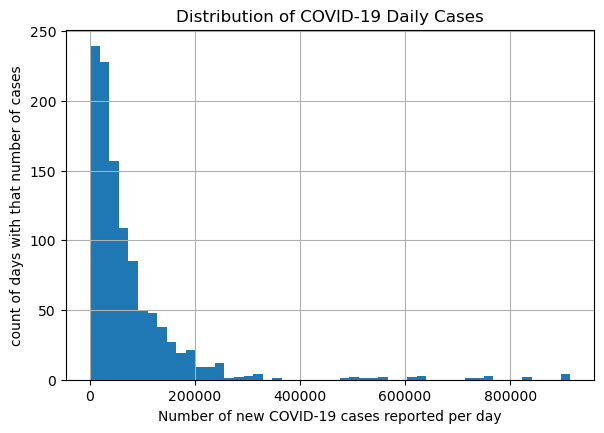

In [15]:
#distribution of covid cases
plt.figure(figsize = (15, 10))
plt.subplot(2,2,2)
trading_days['New_Cases'].hist(bins = 50)
plt.title('Distribution of COVID-19 Daily Cases')
plt.xlabel('Number of new COVID-19 cases reported per day')
plt.ylabel('count of days with that number of cases')

In [16]:
#descriptive statistics
print('S&P 500 Return Statistics:')
print(trading_days['SP500_Daily_Return'].describe())
print("\n COVID-19 Cases Statistics:")
print(trading_days['New_Cases'].describe())

S&P 500 Return Statistics:
count    1083.000000
mean        0.000486
std         0.014033
min        -0.119841
25%        -0.005438
50%         0.000277
75%         0.007382
max         0.093828
Name: SP500_Daily_Return, dtype: float64

 COVID-19 Cases Statistics:
count      1084.000000
mean      76257.214022
std      109918.669935
min           0.000000
25%       20183.250000
50%       44723.500000
75%       89682.250000
max      914412.000000
Name: New_Cases, dtype: float64


Text(0.5, 1.0, 'Correlation Matrix (COVID, Mobility, and Market Returns)')

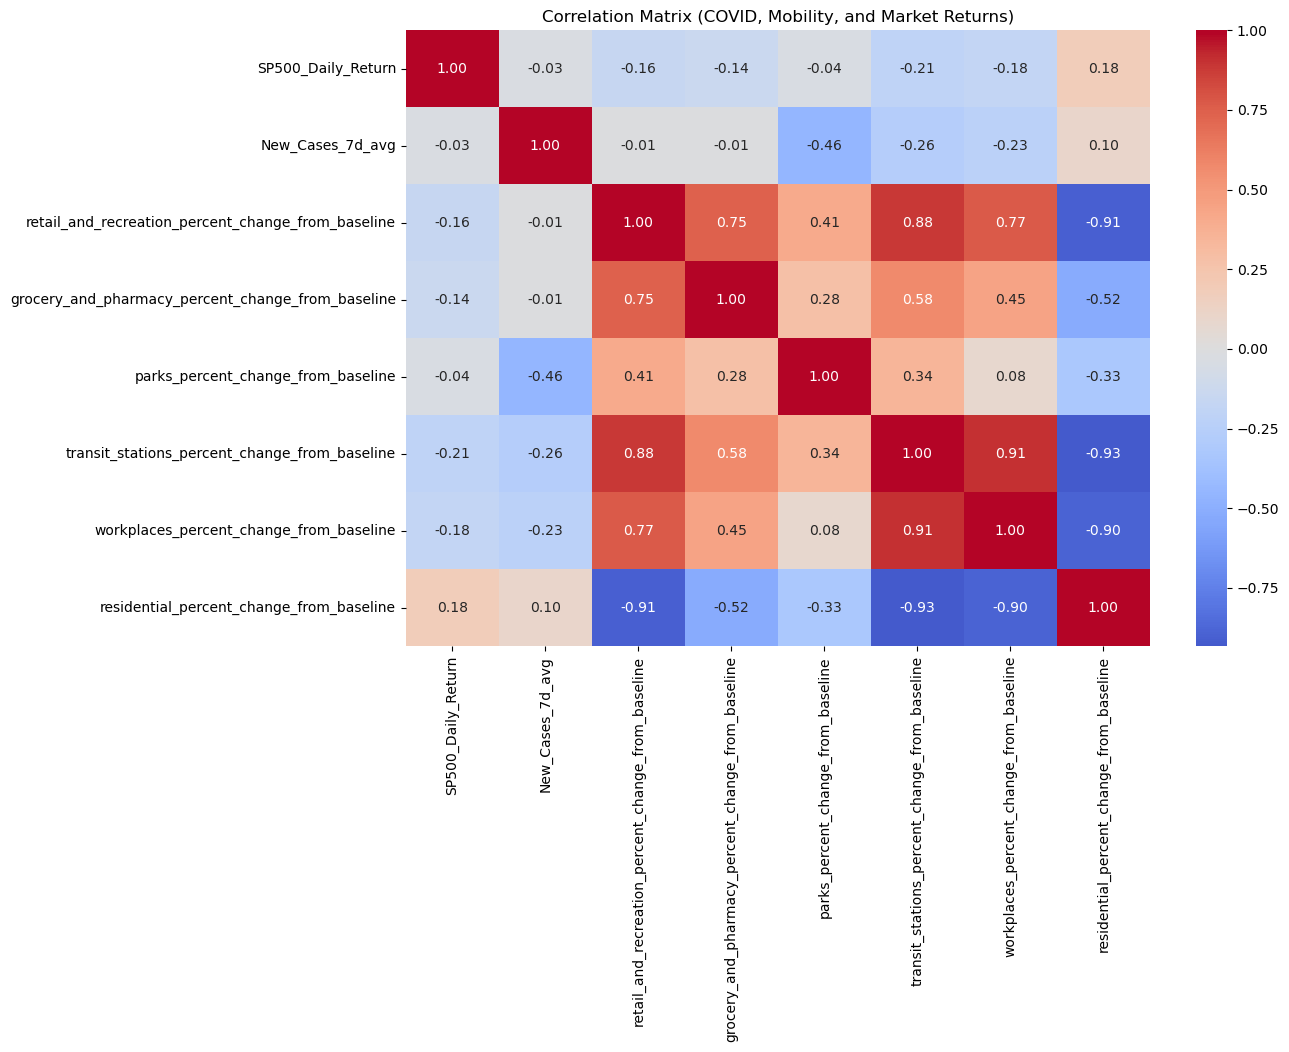

In [17]:
#additional correlation analysis
# Define mobility columns from your dataset
mobility_cols = [
    'retail_and_recreation_percent_change_from_baseline',
    'grocery_and_pharmacy_percent_change_from_baseline',
    'parks_percent_change_from_baseline',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline'
]

# Create correlation matrix
corr_df = project_df[['SP500_Daily_Return', 'New_Cases_7d_avg'] + mobility_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix (COVID, Mobility, and Market Returns)')

#### Hypothesis Testing

In [19]:
from scipy import stats

# Create a temporary DataFrame with just the columns we need
temp_df = project_df[['workplaces_percent_change_from_baseline', 
                     'residential_percent_change_from_baseline',
                     'SP500_Daily_Return']].dropna()

# Test workplace mobility vs S&P returns
wp_corr, wp_p = stats.pearsonr(
    temp_df['workplaces_percent_change_from_baseline'],
    temp_df['SP500_Daily_Return']
)

# Test residential mobility vs S&P returns
res_corr, res_p = stats.pearsonr(
    temp_df['residential_percent_change_from_baseline'],
    temp_df['SP500_Daily_Return']
)

print("Workplace Mobility vs S&P Returns:")
print(f"Correlation: {wp_corr:.3f}, p-value: {wp_p:.4f}")
print(f"Interpretation: {'Significant' if wp_p < 0.05 else 'Not significant'} relationship")

print("\nResidential Mobility vs S&P Returns:")
print(f"Correlation: {res_corr:.3f}, p-value: {res_p:.4f}")
print(f"Interpretation: {'Significant' if res_p < 0.05 else 'Not significant'} relationship")

# Show how many observations were used
print(f"\nAnalysis performed on {len(temp_df)} trading days with complete data")

Workplace Mobility vs S&P Returns:
Correlation: -0.185, p-value: 0.0046
Interpretation: Significant relationship

Residential Mobility vs S&P Returns:
Correlation: 0.178, p-value: 0.0064
Interpretation: Significant relationship

Analysis performed on 233 trading days with complete data


#### Machine Learning

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

features = mobility_cols + [
    'New_Cases_7d_avg',
    'New_Cases_lag_7',
    'workplaces_percent_change_from_baseline_lag7'
]

# Remove rows with missing values
model_df = project_df[features + ['SP500_Daily_Return']].dropna()
X = model_df[features]
y = model_df['SP500_Daily_Return']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
print(f"R² Score: {rf.score(X_test, y_test):.3f}")

# Feature importance
pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

R² Score: -0.579


,Feature,Importance
1,grocery_and_pharmacy_percent_change_from_baseline,0.336925
6,New_Cases_7d_avg,0.120785
8,workplaces_percent_change_from_baseline_lag7,0.107999
7,New_Cases_lag_7,0.100983
3,transit_stations_percent_change_from_baseline,0.087688
2,parks_percent_change_from_baseline,0.071265
0,retail_and_recreation_percent_change_from_base...,0.065428
4,workplaces_percent_change_from_baseline,0.054848
5,residential_percent_change_from_baseline,0.054079


In [22]:
#Classification approach
from sklearn.ensemble import RandomForestClassifier

# Create  target (up/down days)
project_df['Market_Up'] = (project_df['SP500_Daily_Return'] > 0).astype(int)

# Prepare data
model_df = project_df[features + ['Market_Up']].dropna()
X = model_df[features]
y = model_df['Market_Up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
print(f"Accuracy: {clf.score(X_test, y_test):.3f}")
print("\nFeature Importances:")
pd.DataFrame({
    'Feature': features,
    'Importance': clf.feature_importances_
}).sort_values('Importance', ascending=False)

Accuracy: 0.348

Feature Importances:


,Feature,Importance
6,New_Cases_7d_avg,0.153561
2,parks_percent_change_from_baseline,0.146101
7,New_Cases_lag_7,0.140741
4,workplaces_percent_change_from_baseline,0.108979
3,transit_stations_percent_change_from_baseline,0.104909
8,workplaces_percent_change_from_baseline_lag7,0.095961
0,retail_and_recreation_percent_change_from_base...,0.093174
1,grocery_and_pharmacy_percent_change_from_baseline,0.092800
5,residential_percent_change_from_baseline,0.063774


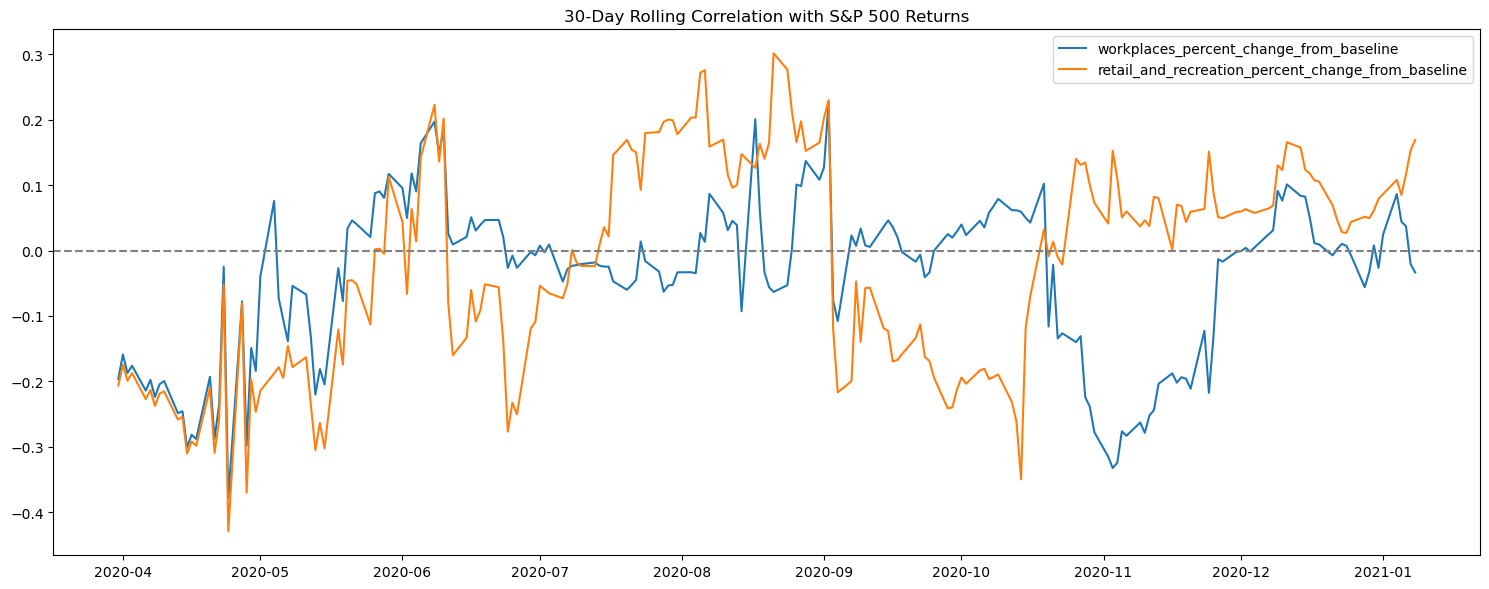

In [23]:
#Rolling Correlations
# Calculate 30-day rolling correlations
rolling_corrs = pd.DataFrame(index=project_df.index)

for col in mobility_cols:
    rolling_corrs[col] = project_df['SP500_Daily_Return'].rolling(30).corr(project_df[col])

# Plot
plt.figure(figsize=(15, 6))
for col in ['workplaces_percent_change_from_baseline', 
            'retail_and_recreation_percent_change_from_baseline']:
    plt.plot(rolling_corrs.index, rolling_corrs[col], label=col)

plt.axhline(0, color='gray', linestyle='--')
plt.title('30-Day Rolling Correlation with S&P 500 Returns')
plt.legend()
plt.tight_layout()

In [24]:
#save project dataframe
project_df.to_csv('cellis3_projectcheckin.csv')

In [46]:
project_df.dtypes

New_Cases                                                      int64
New_Deaths                                                     int64
Value                                                        float64
retail_and_recreation_percent_change_from_baseline           float64
grocery_and_pharmacy_percent_change_from_baseline            float64
parks_percent_change_from_baseline                           float64
transit_stations_percent_change_from_baseline                float64
workplaces_percent_change_from_baseline                      float64
residential_percent_change_from_baseline                     float64
SP500_Daily_Return                                           float64
New_Cases_7d_avg                                             float64
New_Cases_12d_avg                                            float64
retail_and_recreation_percent_change_from_baseline_change    float64
grocery_and_pharmacy_percent_change_from_baseline_change     float64
parks_percent_change_from_baseline

In [48]:
project_df.index

DatetimeIndex(['2020-02-17', '2020-02-18', '2020-02-19', '2020-02-20',
               '2020-02-21', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28',
               ...
               '2024-04-01', '2024-04-02', '2024-04-03', '2024-04-04',
               '2024-04-05', '2024-04-08', '2024-04-09', '2024-04-10',
               '2024-04-11', '2024-04-12'],
              dtype='datetime64[ns]', name='Date', length=1085, freq=None)